## 12. Seq2seq으로 한영 번역기 만들기

Step 2. 데이터 정제
set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않습니다. 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의하세요!

타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수를 이용하여 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

Step 3. 데이터 토큰화
앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

❗ 주의: 난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

Step 4. 모델 설계
한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아집니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

Step 5. 훈련하기
훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

### 1. 데이터 준비

In [144]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
kor_text_file = "korean-english-park.train.ko"
eng_text_file = "korean-english-park.train.en"

In [4]:
# 데이터 읽어오기
def read_data(file_path):
    with open(file_path, "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")
    for sentence in raw[:5]:
        print(">>", sentence)

    return raw

In [13]:
kor_text = read_data(kor_text_file)
eng_text = read_data(eng_text_file)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


In [18]:
# 랜덤하게 문장을 추출하여 한영 번역 결과 확인
index = 27
print(kor_text[index])
print(eng_text[index])

어휘 :
The Geneva-based commission, in its annual study of the industry titled “World Robotics 2001,” said a record 100,000 robots were installed last year, up 25 percent on 1999.


#### 분석
- 한글과 영어의 번역 매칭이 맞지 않은 경우가 다수 발견됨

In [9]:
# 중복 제거
kor_text_cleaned = list(set(kor_text))
eng_text_cleaned = list(set(eng_text))
print("중복제거 후 문장 수: ", len(kor_text_cleaned), len(eng_text_cleaned))

문장 수:  77591 75598


#### 분석
- 각각 중복 제거했을 때, 데이터 크기가 맞지 않는 문제가 있음 --> **pandas DataFrame으로 변환하고 drop_duplicates 이용**

In [24]:
# 데이터를 DataFrame으로 변환
data = pd.DataFrame({"kor": kor_text, "eng": eng_text})
print(f'데이터 크기: {len(data)}')

데이터 크기: 94123


In [25]:
# 중복 제거
data = data.drop_duplicates(subset=['kor'])
print(f'중복 제거 후 데이터 크기: {len(data)}')

중복 제거 후 데이터 크기: 77591


In [26]:
# 문장 단위 텍스트 전처리
def preprocess_sentence(sentence):
    # 소문자 변환
    sentence = sentence.lower()

    # 문장 부호 간 띄어쓰기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 숫자 간 띄어쓰기
    sentence = re.sub(r"([0-9]+)", r" \1 ", sentence)
    
    # 알파벳 한글 간 띄어쓰기
    sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence)

    # 알파벳, 한글, 숫자, 문장부호를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub("[^a-zA-Z0-9가-힣?.!,]", " ", sentence)

    # 빈 칸 반복되는 것 하나로 줄이기
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 문장 앞 뒤 공백 자르기
    sentence = sentence.strip()

    return sentence

In [29]:
# 데이터셋 단위 전처리
def preprocess_data(data):
    kor = []
    eng = []
    for k, e in zip(data['kor'], data['eng']):
        kor.append(preprocess_sentence(k))
        eng.append(preprocess_sentence(e))

    return kor, eng

In [32]:
kor_text_preprocessed, eng_text_preprocessed = preprocess_data(data)

### 2. 한글 토큰화

In [33]:
# 형태소 분석기로 Mecab 이용
from konlpy.tag import Mecab

mecab = Mecab()

In [34]:
# 형태소 분석기 테스트
print(mecab.morphs(kor_text_preprocessed[0]))

['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']


In [84]:
# 한글 토큰화 함수
# 형태소 분석기를 통해 분리된 토큰의 갯수가 지정된 갯수보다 작아야 말뭉치에 포함됨
# 영어는 띄어쓰기 단위로 분리하고, 시작 토큰과 종료 토큰이 추가됨
def tokenize(kor_data, eng_data, max_token_length):
    kor = []
    eng = []
    for (kor_sen, eng_sen) in zip(kor_data, eng_data):
        try:
            kor_token = mecab.morphs(kor_sen)
            eng_token = ("<start> " + eng_sen + " <end>").split(" ")
            if len(kor_token) < max_token_length:
                kor.append(kor_token)
                eng.append(eng_token)
        except:
            print(kor_sen, eng_sen)

    return kor, eng

In [85]:
# 한글의 최대 토큰 길이를 50
kor_corpus, eng_corpus = tokenize(kor_text_preprocessed, eng_text_preprocessed, 50)

#### 디버깅
- 아래와 같은 에러메시지
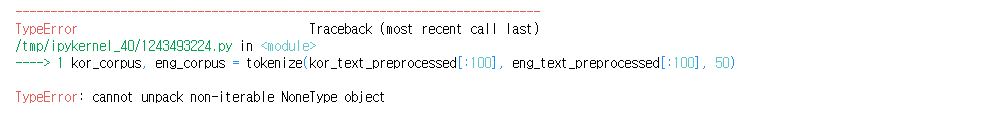
- tokenize() 함수의 리턴값이 없어서 발생하는 문제임

In [86]:
# 토큰 인덱스로 변환
def tokenize_index(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [87]:
enc_tensor, enc_tokenizer = tokenize_index(kor_corpus)
dec_tensor, dec_tokenizer = tokenize_index(eng_corpus)

### 3. 모델 설계

In [88]:
# 어텐션 함수
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)
        print(context_vec.shape, attn.shape)

        return context_vec, attn

In [89]:
# 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [90]:
# 디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

### 4. 훈련

In [190]:
# 옵티마이저
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# 손실 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [191]:
# 학습 스탭 정의
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        print(enc_out.shape)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [193]:
# train_step을 호출하여 실제 모델 학습 수행 
from tqdm import tqdm
import random

TRAIN_SAMPLE = 5
enc_train = enc_tensor[:TRAIN_SAMPLE]
dec_train = dec_tensor[:TRAIN_SAMPLE]

BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE], dec_train[idx:idx+BATCH_SIZE], encoder, decoder, optimizer, dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

  0%|          | 0/1 [00:00<?, ?it/s]

(5, 49, 512)
(5, 49, 512)


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s, Loss 1.2868]


#### 디버깅
- BATCH_SIZE: 64, units: 1024, embedding_dim: 512에서 메모리 부족 에러 발생

### 5. 시각화

In [ ]:
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

#mpl.font_manager.findfont(font)
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')

In [195]:
# 어텐션 값을 시각화
def plot_attention(attention, sentence, predicted_sentence):
    print(attention.shape)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

### 6. 평가

In [194]:
# 입력된 문장으로부터 디코더 출력을 얻어오는 함수 - 번역된 문장을 얻어온다
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
   
    #inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = mecab.morphs(sentence)
    inputs = enc_tokenizer.texts_to_sequences(inputs)
    print(inputs, type(inputs))

    res = []
    for element in inputs:
        res += element
    inputs = [res]
    print(inputs, type(res))

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=enc_train.shape[-1], padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [196]:
# 번역과 어텐션 매트릭스 출력을 한 번에 처리하는 함수
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

[[1738], [832], [6], [2734], [201], [113], [3], [13912], [399], [38], [12], [14], [62], [1]] <class 'list'>
[[1738, 832, 6, 2734, 201, 113, 3, 13912, 399, 38, 12, 14, 62, 1]] <class 'list'>
Input: 대법원 판사의 은퇴 가능성이 빈번히 언급되고 있습니다 .
Predicted translation: <end> 
(1, 8)


/tmp/ipykernel_40/169424178.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_40/169424178.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


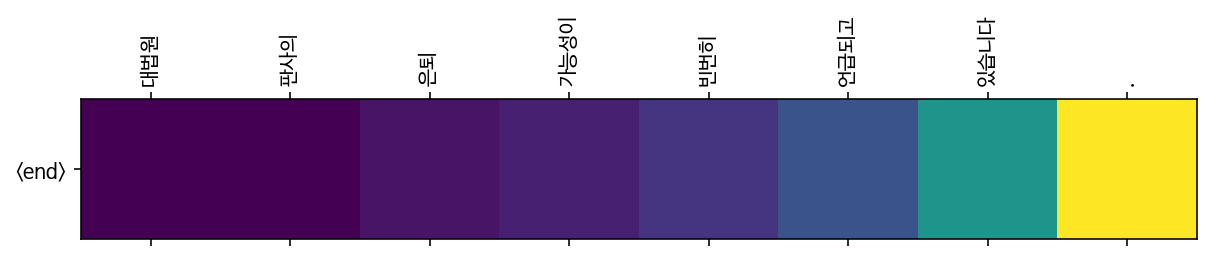

In [197]:
# 테스트 케이스 1 - 학습된 문장
translate("대법원 판사의 은퇴 가능성이 빈번히 언급되고 있습니다.", encoder, decoder)

In [ ]:
# 테스트 케이스 2 - 새로운 문장
translate("어떻게 지내니?", encoder, decoder)

#### 분석
- 분석 결과 쓰기

### 회고
- 회고 결과 쓰기